# Parameter Response Maps for the NN emulators

Import modules

In [1]:
import numpy as np
from scipy.io import netcdf as nc
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

Select output variables

In [3]:
var = ["GPP", "LHF"]
nvar = len(var)

Read in PPE modes, Obs modes, default modes

In [4]:
PPE_modes = [np.load("../outputdata/outputdata_"+v+"_SVD_3modes.npy") for v in var]
Fobs = [np.load("../obs/obs_"+v+"_SVD_3modes.npy") for v in var]
default_modes = [np.load("../outputdata/modeldefault_"+v+"_SVD_3modes.npy") for v in var]

In [5]:
nmodes = PPE_modes[0].shape[1]

Read in % variance, obs sd

In [6]:
# variance recorded in NN develop and test spreadsheet, taken from SVD.ipynb
var_modes = [[0.83406484, 0.1348919, 0.01192334],[0.7701996, 0.12915632, 0.05642754]]
obs_sd = [np.load("../obs/obs_"+v+"_SVD_3modes_allyrs_sd.npy") for v in var]

Load pre-trained models

In [7]:
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kd

In [8]:
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

In [9]:
NN_models = [load_model("../emulators/NN_"+v+"_finalize_multi-dim.h5", 
    custom_objects={'mean_sq_err' :mean_sq_err}) for v in var]

W1110 16:48:16.178198 140090801682176 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1110 16:48:16.192234 140090801682176 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1110 16:48:16.247070 140090801682176 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1110 16:48:16.247914 140090801682176 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto 

In [10]:
# Fix random seed for reproducibility
np.random.seed(9)

Read in inflated ensemble

In [11]:
inputdata_inflate = np.load(file="../lhc_1000.npy", allow_pickle=True)

Make predictions

In [12]:
PPE_inflate_preds = [NN_models[i].predict(inputdata_inflate) for i,v in enumerate(var)]

Define target cost function value based on ClM default parameter set

In [13]:
target_terms = [np.sum(var_modes[i]*((default_modes[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # mode wgt
target_val = np.sum(target_terms)
target_val

1227.268796359131

Calculate cost function values based on CLM PPE

In [14]:
PPE_err_terms = [np.sum(var_modes[i]*((PPE_modes[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
PPE_err = np.sum(PPE_err_terms, axis=0)
PPE_opt = np.argmin(PPE_err)
print(PPE_opt) # ensemble member
print(PPE_err[PPE_opt]) # minimum value for PPE_err

91
78.18192243245684


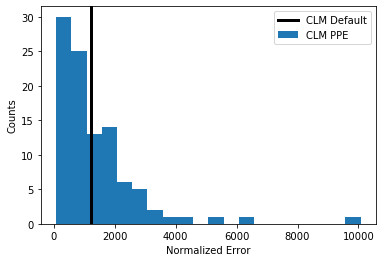

In [15]:
plt.hist(PPE_err, bins=20, label="CLM PPE")
plt.xlabel("Normalized Error")
plt.ylabel("Counts")
plt.axvline(x=target_val, color='k', linewidth=3, label="CLM Default")
plt.legend();

Calculate cost function based on inflated emulator predictions

In [16]:
NN_inflate_terms = [np.sum(var_modes[i]*((PPE_inflate_preds[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # mode wgt
# Unweighted multiple objectives
NN_inflate_err = np.sum(NN_inflate_terms, axis=0)

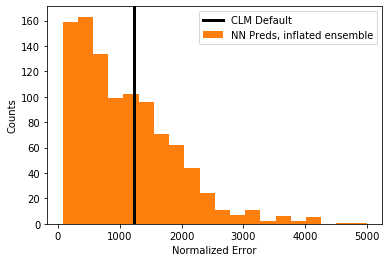

In [17]:
plt.hist(NN_inflate_err, bins=20, color="C1", label="NN Preds, inflated ensemble")
plt.xlabel("Normalized Error")
plt.ylabel("Counts")
plt.axvline(x=target_val, color='k', linewidth=3, label="CLM Default")
plt.legend();

How many parameter sets predict a normalized error better than the default model?

In [18]:
pind_inflate = NN_inflate_err < target_val
sum(pind_inflate)

622

Subset those parameter scaling factors

In [19]:
pscals_inflate = inputdata_inflate[pind_inflate,:]

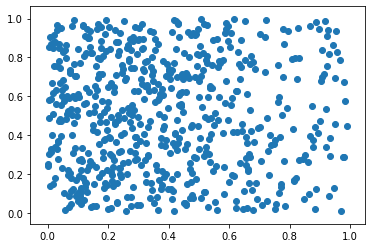

In [20]:
plt.scatter(pscals_inflate[:,0], pscals_inflate[:,1])

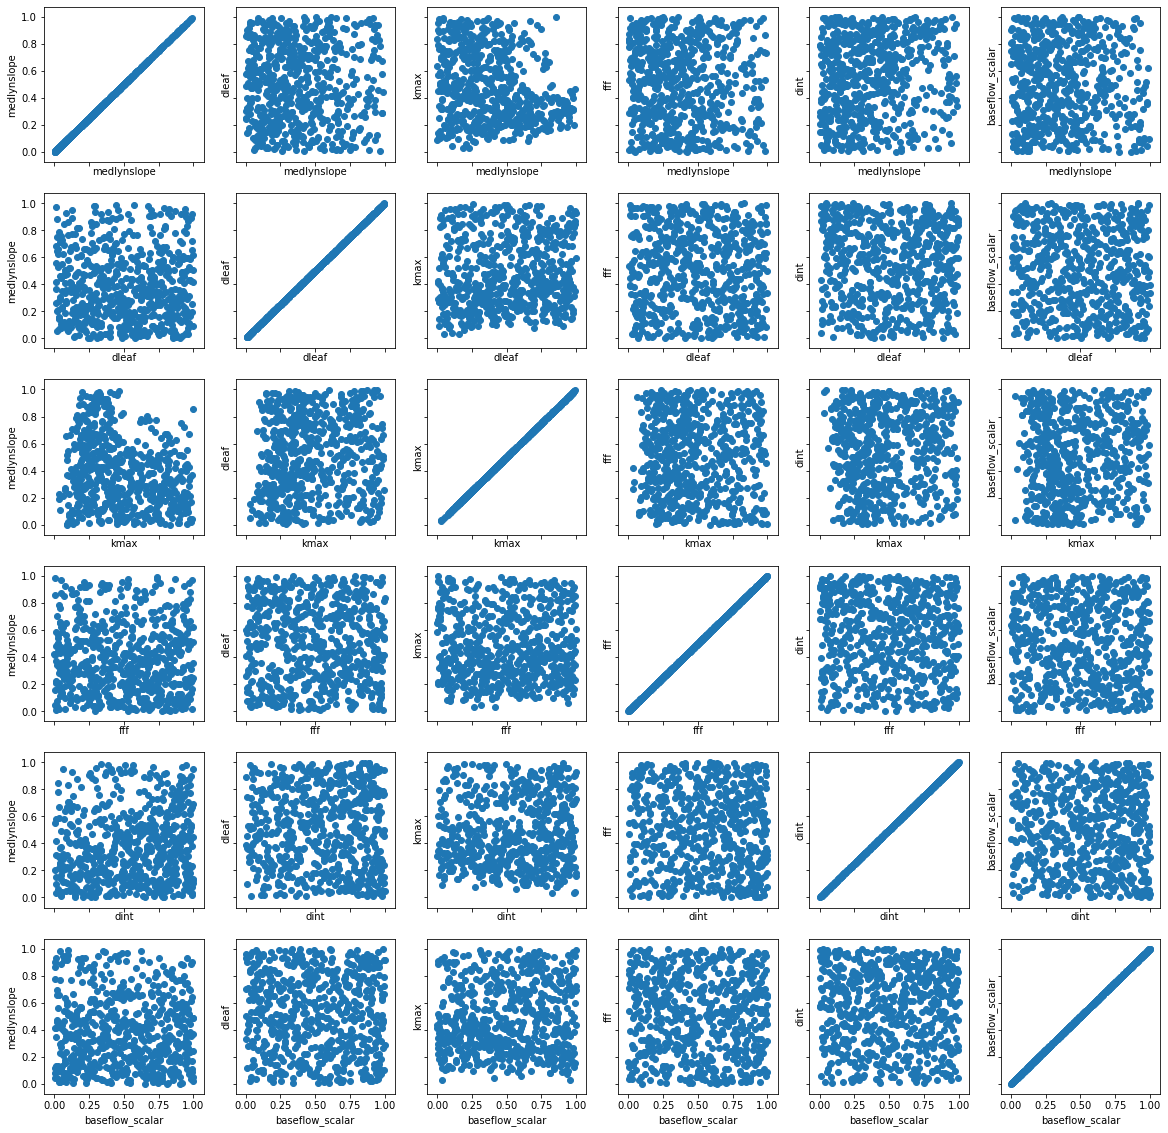

In [21]:
fig, axs = plt.subplots(npar, npar, figsize=(20, 20), sharex=True, sharey=True)
#axs = axs.ravel()

for i in range(npar):
    for j in range(npar):
        axs[i,j].scatter(pscals_inflate[:,i],pscals_inflate[:,j])
        axs[i,j].set_xlabel(in_vars[i])
        axs[i,j].set_ylabel(in_vars[j])
        

### Create a new large LHC (n=10^7)

In [11]:
from pyDOE import *

In [12]:
samp = 10**7
lhd = lhs(npar, samples=int(samp)) # default sampling criterion = random

In [13]:
lhd.shape

(10000000, 6)

In [14]:
lhd_preds = [NN_models[i].predict(lhd) for i,v in enumerate(var)]

In [15]:
lhd_terms = [np.sum(var_modes[i]*((lhd_preds[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # mode wgt
# Unwebighted multiple objectives
lhd_err = np.sum(lhd_terms, axis=0)

In [27]:
pind = lhd_err < target_val
sum(pind) # too many values when just taking everything less than the target value

6248307

In [16]:
# try the 1000 smallest values (get indices)
pind_1000 = np.argpartition(lhd_err, 1000)[:1000]

In [17]:
pscals = lhd[pind_1000,:]

In [18]:
pscals.shape

(1000, 6)

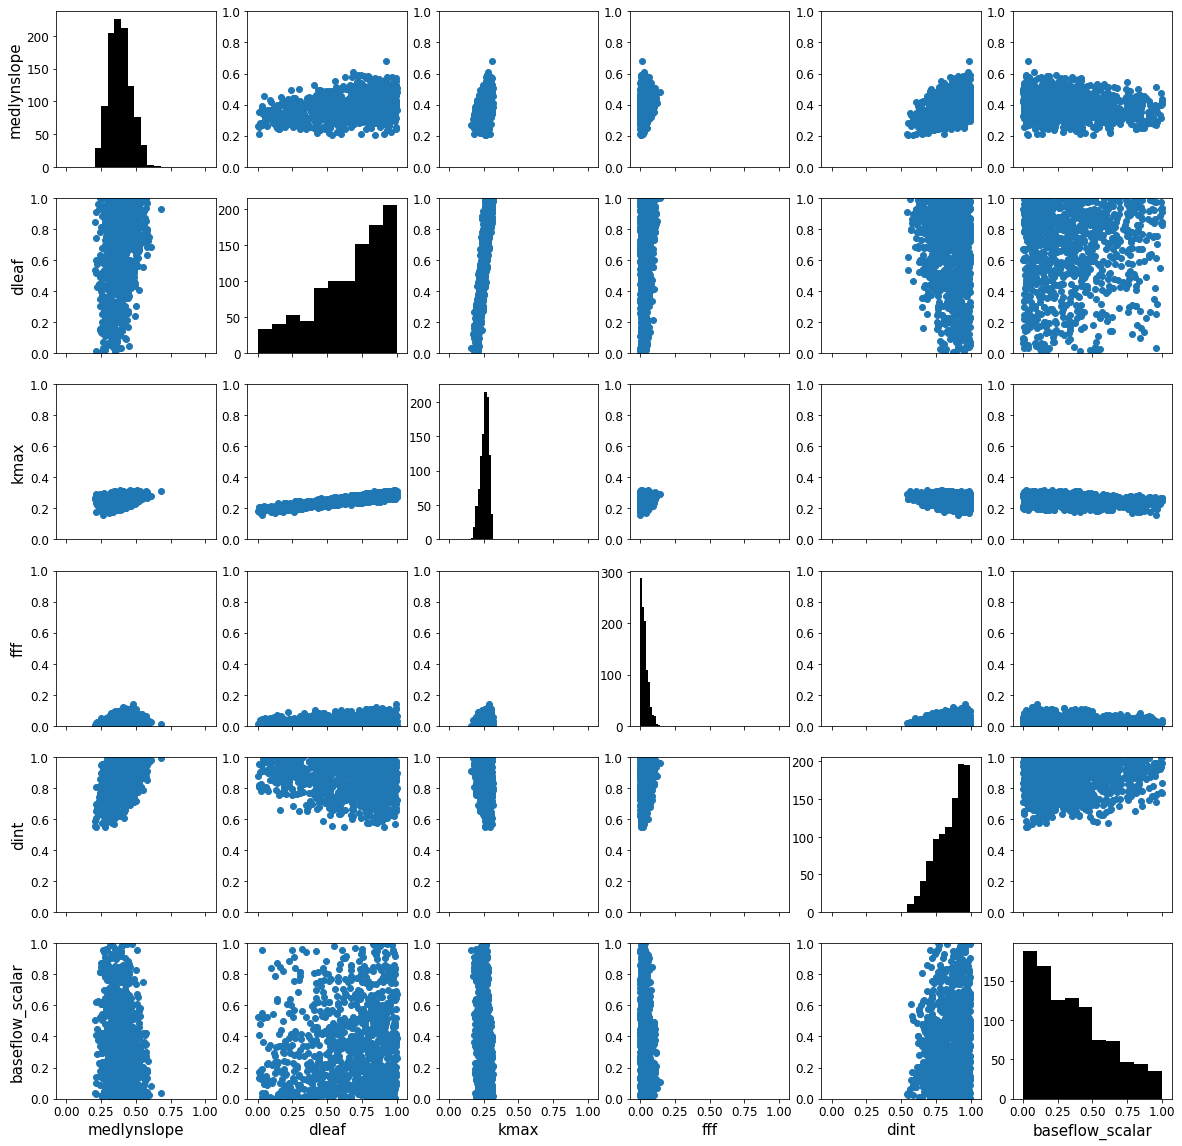

In [19]:
fig, axs = plt.subplots(npar, npar, figsize=(20, 20), sharex=True)
#axs = axs.ravel()

for i in range(npar):
    for j in range(npar):
        if i == j:
            axs[j,i].hist(pscals[:,i], bins=10, color='k')
        else:
            axs[j,i].scatter(pscals[:,i],pscals[:,j])
            axs[j,i].set_ylim(0,1)
        if i == 0:
            axs[j,i].set_ylabel(in_vars[j], fontsize=15)
        if j == npar-1:
            axs[j,i].set_xlabel(in_vars[i], fontsize=15)
            axs[j,i].xaxis.set_tick_params(labelsize='large')
        axs[j,i].yaxis.set_tick_params(labelsize='large')
#plt.savefig("optimal_parameter_response_surfaces_v2.pdf")

zoom in on a subset of 4 parameters

In [64]:
pscals_subset = np.append(pscals[:,:1], pscals[:,2:5], axis=1)
pscals_subset.shape

(1000, 4)

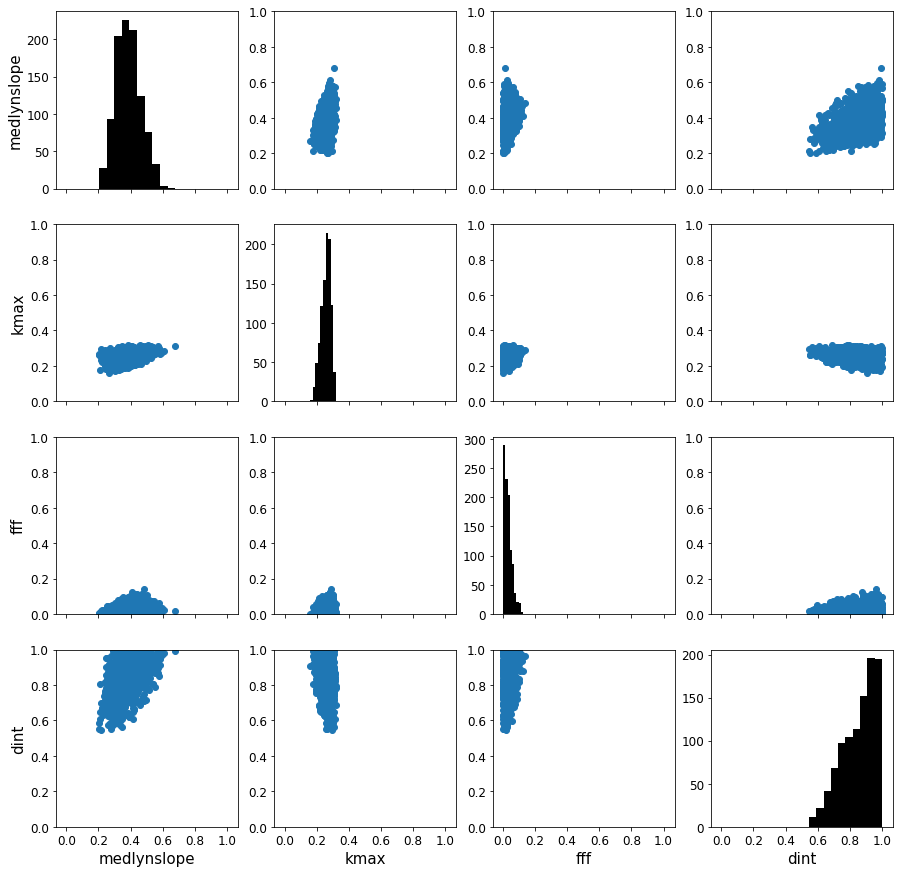

In [68]:
var_subset = ['medlynslope','kmax','fff','dint']
npar_subset = len(var_subset)
fig, axs = plt.subplots(npar_subset, npar_subset, figsize=(15, 15), sharex=True)

for i in range(npar_subset):
    for j in range(npar_subset):
        if i == j:
            axs[j,i].hist(pscals_subset[:,i], bins=10, color='k')
        else:
            axs[j,i].scatter(pscals_subset[:,i],pscals_subset[:,j])
            axs[j,i].set_ylim(0,1)
        if i == 0:
            axs[j,i].set_ylabel(var_subset[j], fontsize=15)
        if j == npar_subset-1:
            axs[j,i].set_xlabel(var_subset[i], fontsize=15)
            axs[j,i].xaxis.set_tick_params(labelsize='large')
        axs[j,i].yaxis.set_tick_params(labelsize='large')
#plt.savefig("optimal_parameter_response_surfaces_subset.pdf")

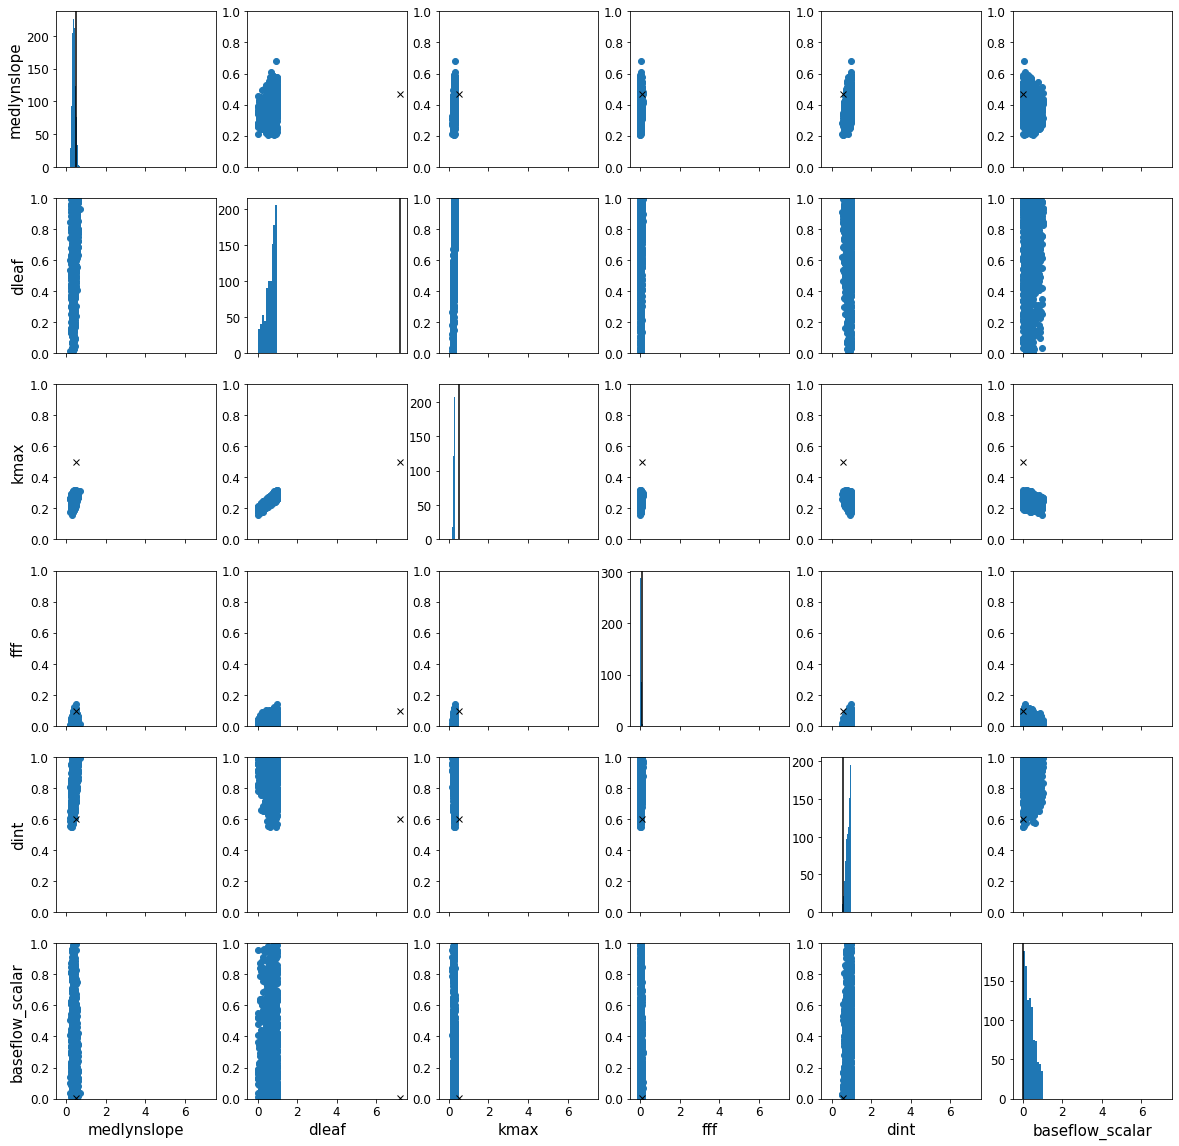

In [20]:
# with some default values (lines on distributions, points on scatterplots)
#defscals = [0,0,0.5,0.096385542,0.6,0.005025126] # from Sensitivity spreadsheet; placeholder zeros for first 2 for now (PFT-varying)
defscals = [0.469468382, 7.180531279, 0.5, 0.096385542, 0.6, 0.005025126] # avg across PFTs for first 2
fig, axs = plt.subplots(npar, npar, figsize=(20, 20), sharex=True)
#axs = axs.ravel()

for i in range(npar):
    for j in range(npar):
        if i == j:
            axs[j,i].hist(pscals[:,i], bins=10)
            axs[j,i].axvline(x=defscals[i], color='k')
        else:
            axs[j,i].scatter(pscals[:,i],pscals[:,j])
            axs[j,i].set_ylim(0,1)
            axs[j,i].plot(defscals[i],defscals[j],'kx')
        if i == 0:
            axs[j,i].set_ylabel(in_vars[j], fontsize=15)
        if j == npar-1:
            axs[j,i].set_xlabel(in_vars[i], fontsize=15)
            axs[j,i].xaxis.set_tick_params(labelsize='large')
        axs[j,i].yaxis.set_tick_params(labelsize='large')
#plt.savefig("optimal_parameter_response_surfaces_v2.pdf")

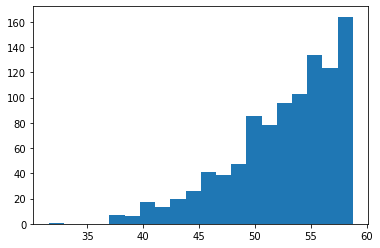

In [21]:
# sanity check: what are the errors for the pind_1000 parameter indices?
plt.hist(lhd_err[pind_1000], bins=20);

In [22]:
# What is the maximum error?
maxerr = np.max(lhd_err[pind_1000])
maxerr

58.77035373079402

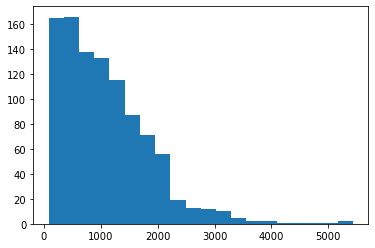

In [23]:
# compare to the first 1000 parameter indices, unranked
plt.hist(lhd_err[:1000], bins=20);

In [24]:
lhd_opt = np.argmin(lhd_err)
#print(lhd_opt)
print(lhd_err[lhd_opt]) # minimum value for lhd_err
print(lhd[lhd_opt,:]) # parameter scalers for optimal set

31.522332743880163
[0.48211064 0.98032683 0.30232912 0.01379284 0.92644518 0.04157548]


Plot the predicted EOF modes for the subset of optimal parameters

In [35]:
opt_modes = [lhd_preds[i][pind_1000,:] for i,v in enumerate(var)]

In [36]:
opt_modes[0].shape

(1000, 3)

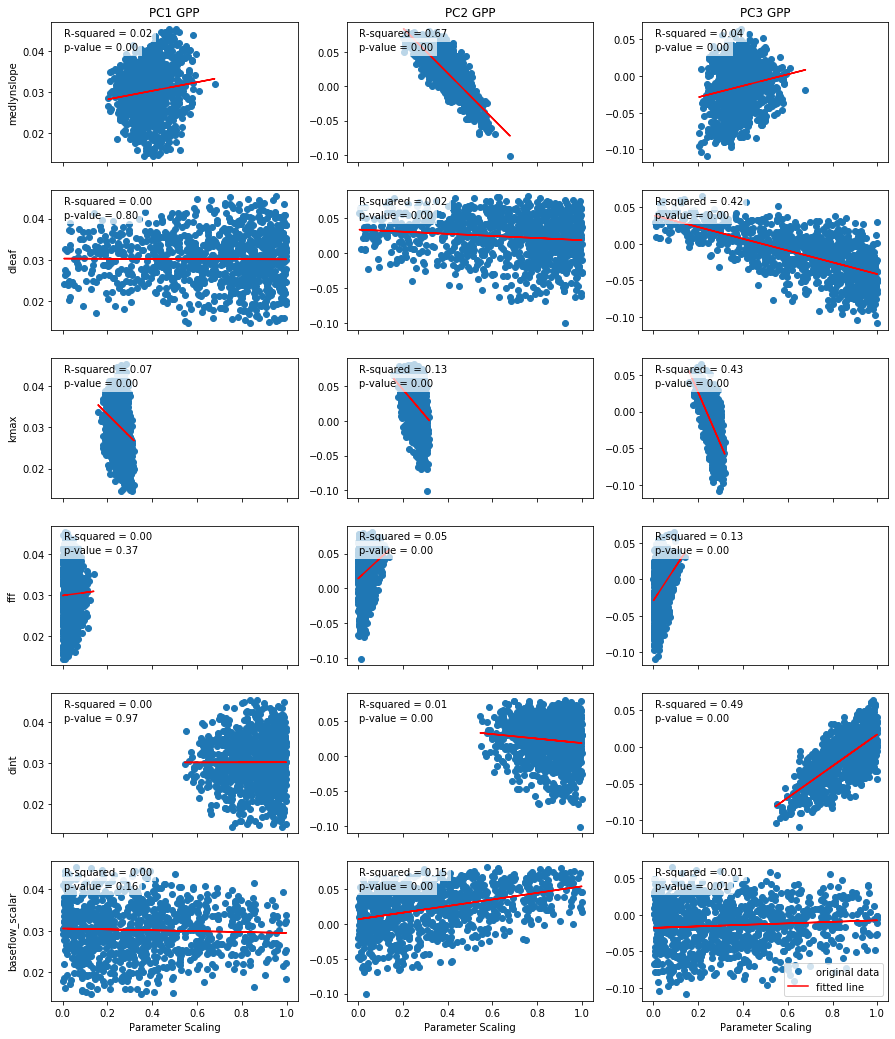

In [37]:
fig, axs = plt.subplots(npar, nmodes, figsize=(15,18), sharex=True)
#axs = axs.ravel()
for j in range(nmodes):
    for i in range(npar):
        x=pscals[:,i]
        y=opt_modes[0][:,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float),y)
        axs[i,j].plot(x, y, 'o', label='original data')
        axs[i,j].plot(x, intercept + slope*x, 'r', label='fitted line')
        axs[i,j].text(0.05, 0.9, 'R-squared = %0.2f' % r_value**2, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        axs[i,j].text(0.05, 0.8, 'p-value = %0.2f' % p_value, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        if i == 0:
            axs[i,j].set_title('PC'+str(j+1)+' GPP')
        if j == 0:
            axs[i,j].set_ylabel(in_vars[i])
        if i == npar-1:
            axs[i,j].set_xlabel('Parameter Scaling')
plt.legend();  

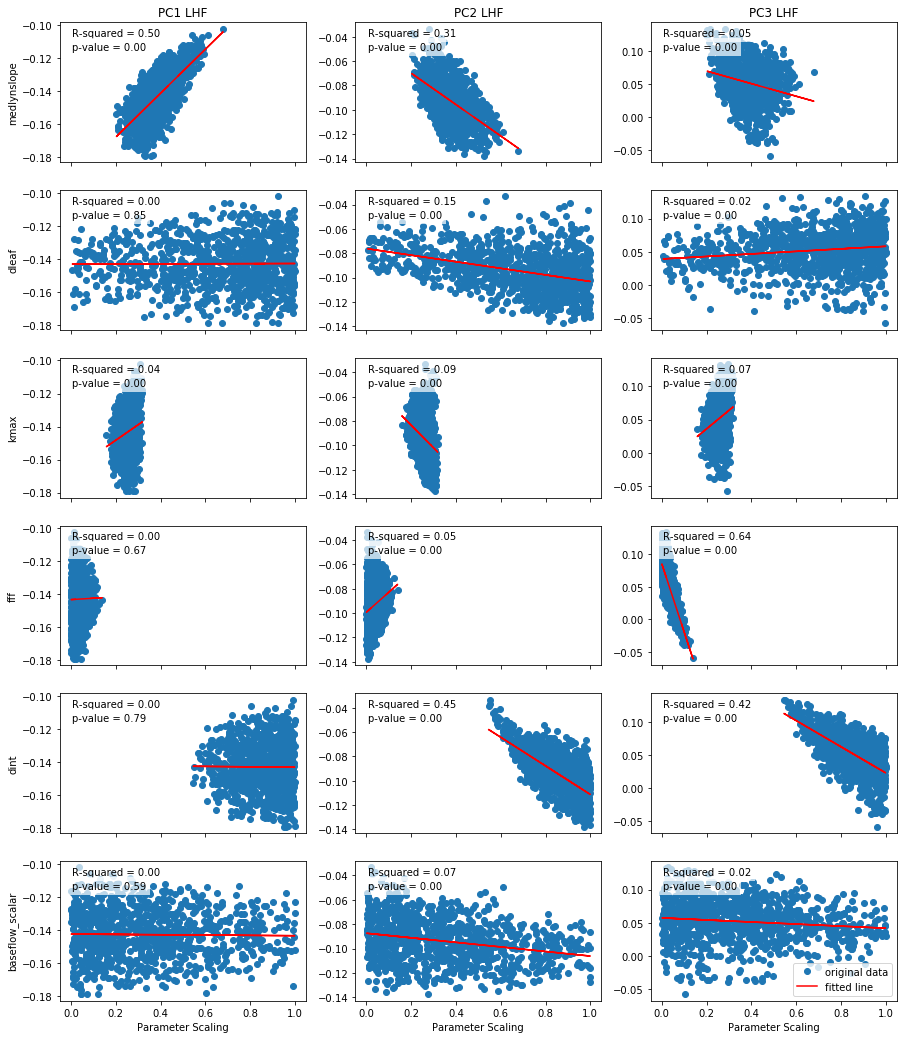

In [41]:
fig, axs = plt.subplots(npar, nmodes, figsize=(15,18), sharex=True)
#axs = axs.ravel()
for j in range(nmodes):
    for i in range(npar):
        x=pscals[:,i]
        y=opt_modes[1][:,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float),y)
        axs[i,j].plot(x, y, 'o', label='original data')
        axs[i,j].plot(x, intercept + slope*x, 'r', label='fitted line')
        axs[i,j].text(0.05, 0.9, 'R-squared = %0.2f' % r_value**2, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        axs[i,j].text(0.05, 0.8, 'p-value = %0.2f' % p_value, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        if i == 0:
            axs[i,j].set_title('PC'+str(j+1)+' LHF')
        if j == 0:
            axs[i,j].set_ylabel(in_vars[i])
        if i == npar-1:
            axs[i,j].set_xlabel('Parameter Scaling')
plt.legend(); 

Plot parameter-parameter scatter plots, color coded by PC mode

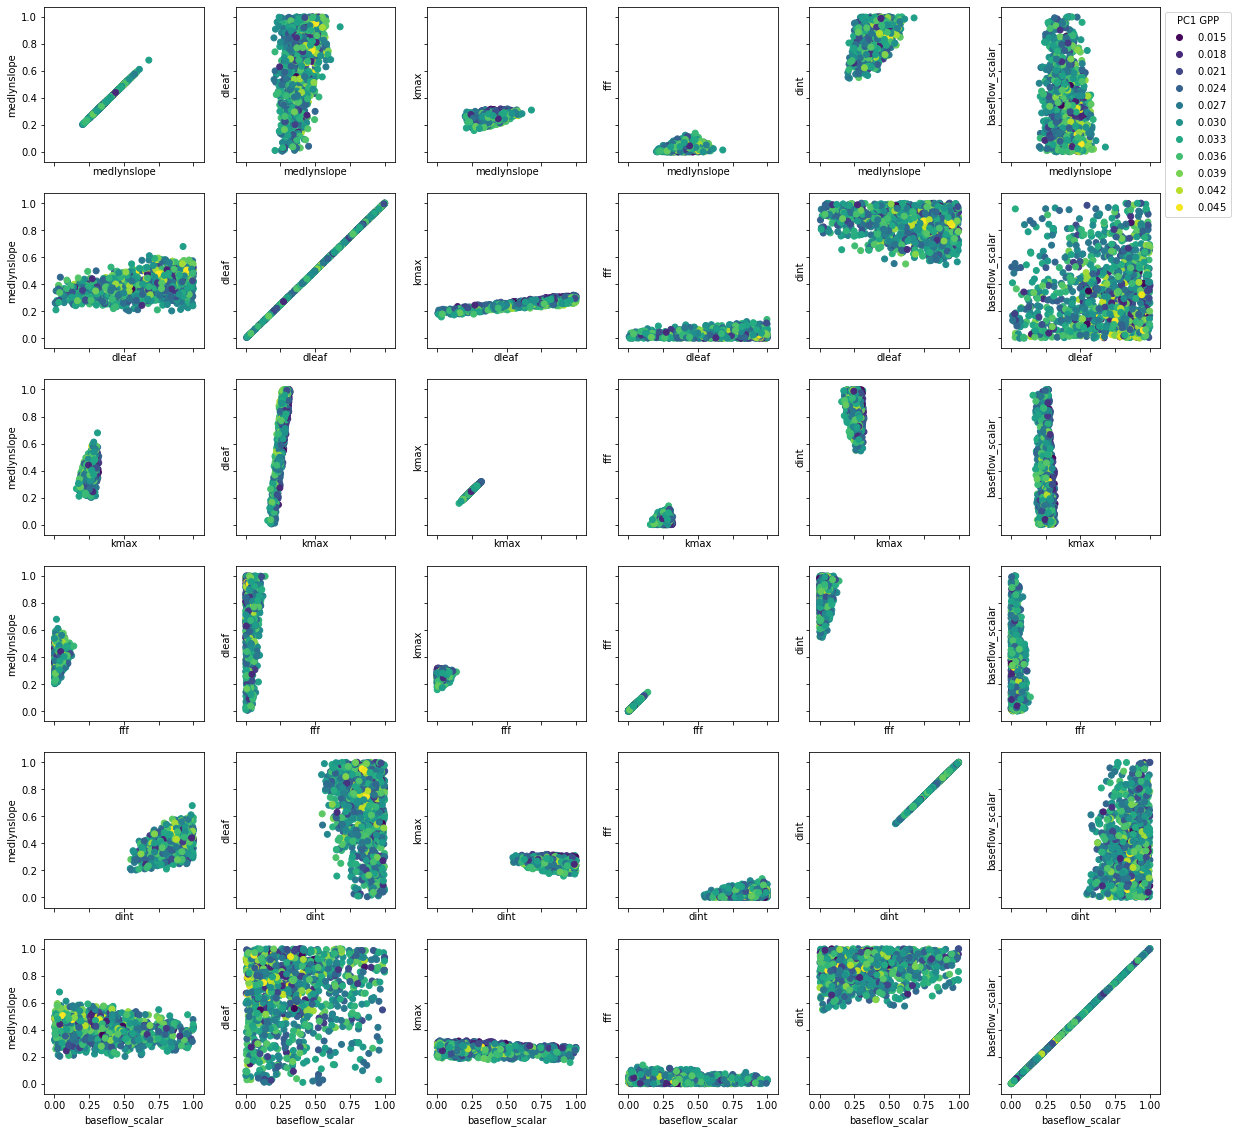

In [40]:
fig, axs = plt.subplots(npar, npar, figsize=(20, 20), sharex=True, sharey=True)
#axs = axs.ravel()

for i in range(npar):
    for j in range(npar):
        scatter=axs[i,j].scatter(pscals[:,i],pscals[:,j], c=opt_modes[0][:,0])
        axs[i,j].set_xlabel(in_vars[i])
        axs[i,j].set_ylabel(in_vars[j])
        if i==0 and j==npar-1:
            axs[i,j].legend(*scatter.legend_elements(),bbox_to_anchor=(1, 1),title="PC1 GPP")

Visualize parameters in 2D mode space (first two modes only)

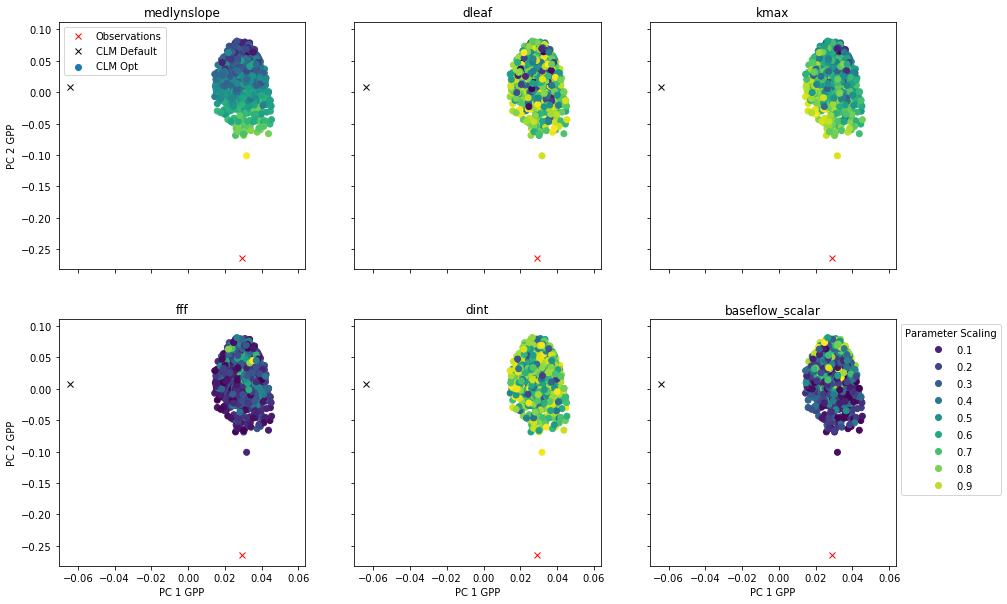

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.ravel()
for i in range(npar):
    scatter=axs[i].scatter(opt_modes[0][:,0],opt_modes[0][:,1], label="CLM Opt", c=pscals[:,i])
    axs[i].plot(Fobs[0][:,0],Fobs[0][:,1], 'xr', label='Observations')
    axs[i].plot(default_modes[0][:,0],default_modes[0][:,1], 'xk', label='CLM Default')
    if i > 2:
        axs[i].set_xlabel("PC 1 "+var[0])
    if i == 0 or i == 3:
        axs[i].set_ylabel("PC 2 "+var[0])
    axs[i].set_title(in_vars[i])
    if i == 0:
        axs[i].legend()
    if i == npar-1:
        axs[i].legend(*scatter.legend_elements(),bbox_to_anchor=(1, 1),title="Parameter Scaling")
#plt.savefig("EOF2vsEOF1_GPP_byparam_withobs.pdf")

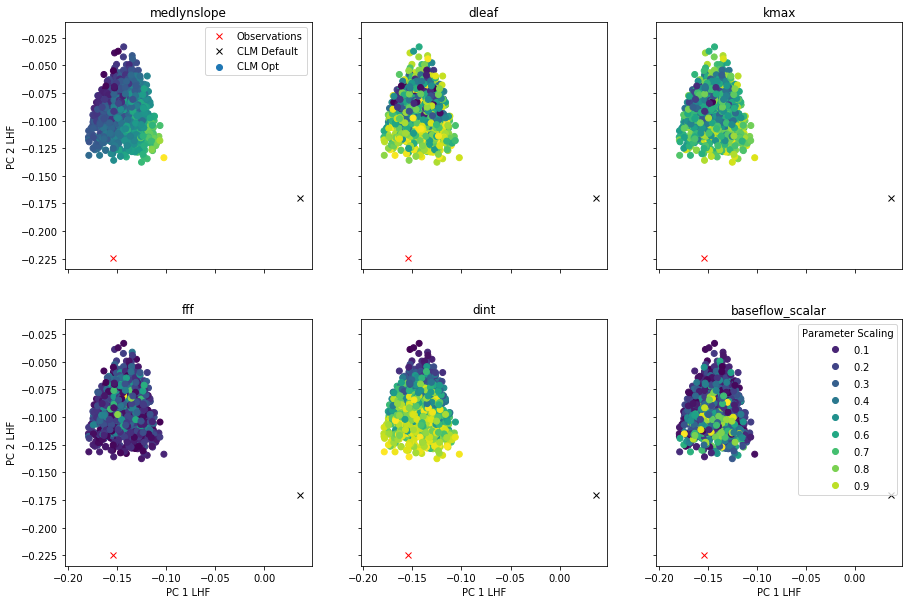

In [53]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.ravel()
for i in range(npar):
    scatter=axs[i].scatter(opt_modes[1][:,0],opt_modes[1][:,1], label="CLM Opt", c=pscals[:,i])
    axs[i].plot(Fobs[1][:,0],Fobs[1][:,1], 'xr', label='Observations')
    axs[i].plot(default_modes[1][:,0],default_modes[1][:,1], 'xk', label='CLM Default')
    if i > 2:
        axs[i].set_xlabel("PC 1 "+var[1])
    if i == 0 or i == 3:
        axs[i].set_ylabel("PC 2 "+var[1])
    axs[i].set_title(in_vars[i])
    if i == 0:
        axs[i].legend()
    if i == npar-1:
        axs[i].legend(*scatter.legend_elements(),bbox_to_anchor=(1, 1),title="Parameter Scaling")
#plt.savefig("EOF2vsEOF1_GPP_byparam_withobs.pdf")

Plot for the original PPE

In [42]:
inputdata = np.load(file="../lhc_100.npy", allow_pickle=True)

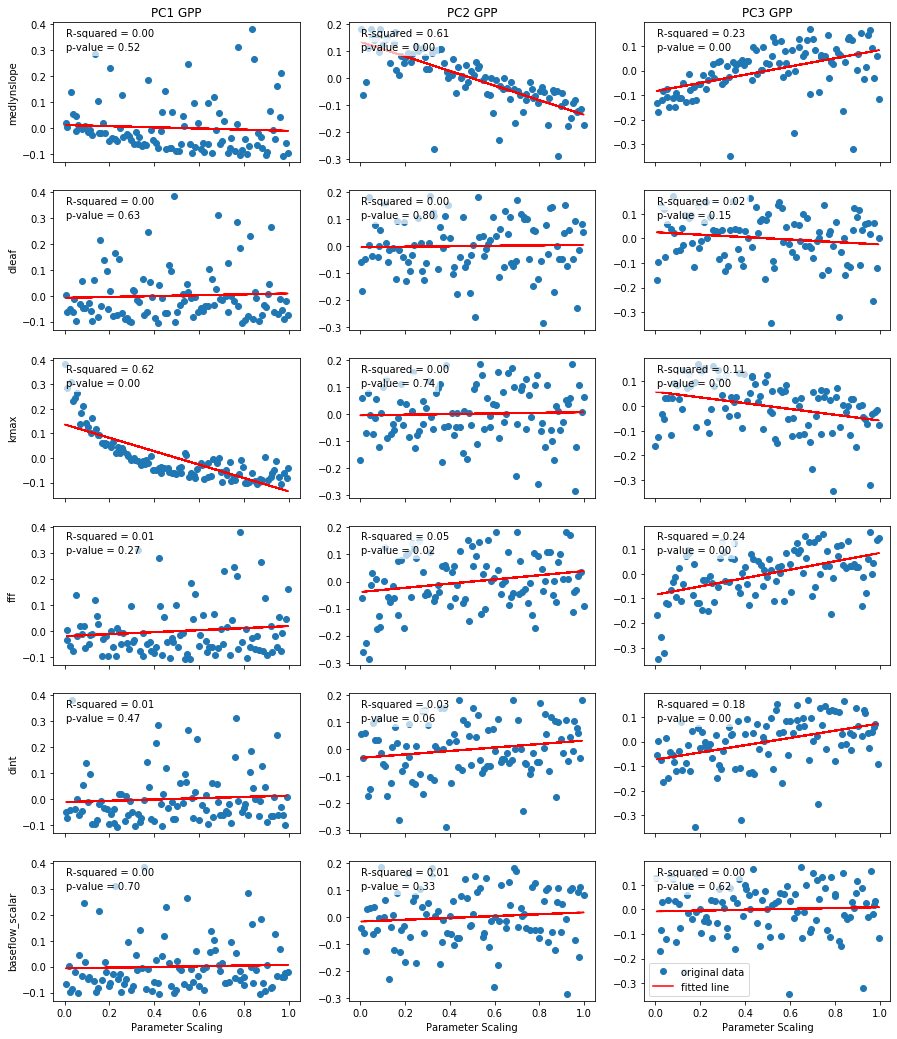

In [43]:
fig, axs = plt.subplots(npar, nmodes, figsize=(15,18), sharex=True)
#axs = axs.ravel()
for j in range(nmodes):
    for i in range(npar):
        x=inputdata[:,i]
        y=PPE_modes[0][:,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x.astype(float),y)
        axs[i,j].plot(x, y, 'o', label='original data')
        axs[i,j].plot(x, intercept + slope*x, 'r', label='fitted line')
        axs[i,j].text(0.05, 0.9, 'R-squared = %0.2f' % r_value**2, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        axs[i,j].text(0.05, 0.8, 'p-value = %0.2f' % p_value, transform=axs[i,j].transAxes, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        if i == 0:
            axs[i,j].set_title('PC'+str(j+1)+' GPP')
        if j == 0:
            axs[i,j].set_ylabel(in_vars[i])
        if i == npar-1:
            axs[i,j].set_xlabel('Parameter Scaling')
plt.legend();  
#plt.savefig("Parameter_regressions_EOF1-3_GPP.pdf")

Remove regression lines

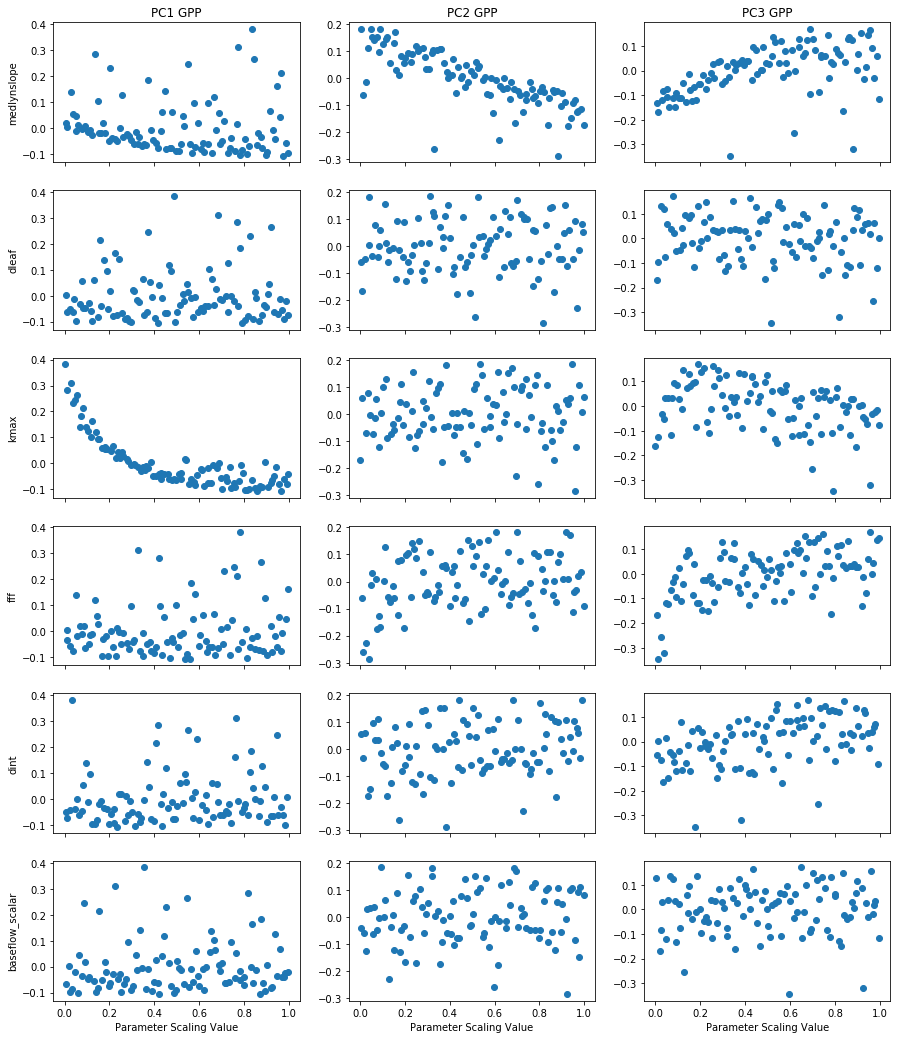

In [44]:
fig, axs = plt.subplots(npar, nmodes, figsize=(15,18), sharex=True)
for j in range(nmodes):
    for i in range(npar):
        x=inputdata[:,i]
        y=PPE_modes[0][:,j]
        axs[i,j].plot(x, y, 'o')
        if i == 0:
            axs[i,j].set_title('PC'+str(j+1)+' GPP')
        if j == 0:
            axs[i,j].set_ylabel(in_vars[i])
        if i == npar-1:
            axs[i,j].set_xlabel('Parameter Scaling Value')
#plt.savefig("Parameter_relations_PC1-3_GPP.pdf")

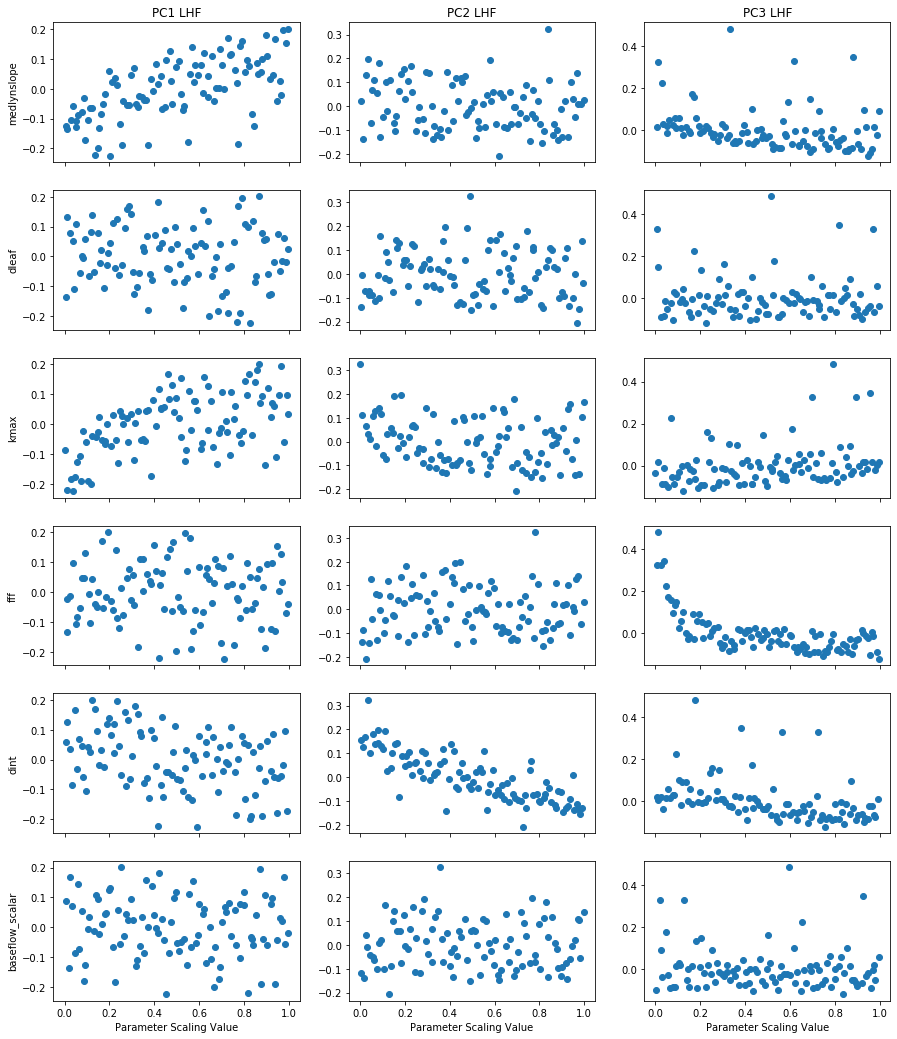

In [45]:
fig, axs = plt.subplots(npar, nmodes, figsize=(15,18), sharex=True)
for j in range(nmodes):
    for i in range(npar):
        x=inputdata[:,i]
        y=PPE_modes[1][:,j]
        axs[i,j].plot(x, y, 'o')
        if i == 0:
            axs[i,j].set_title('PC'+str(j+1)+' LHF')
        if j == 0:
            axs[i,j].set_ylabel(in_vars[i])
        if i == npar-1:
            axs[i,j].set_xlabel('Parameter Scaling Value')
#plt.savefig("Parameter_relations_PC1-3_LHF.pdf")

Try surface plots with 2 parameters (TBD)

In [42]:
#from mpl_toolkits import mplot3d

In [43]:
# test medlynslope/dleaf for GPP mode 1
#ax = plt.axes(projection='3d')
# z input must be 2D
#ax.plot_surface(inputdata[:,0], inputdata[:,1], PPE_modes[0][:,0], rstride=1, cstride=1,
#                cmap='viridis', edgecolor='none')
#ax.set_title('surface');

Plot parameter-parameter scatter plots, color coded by PC mode

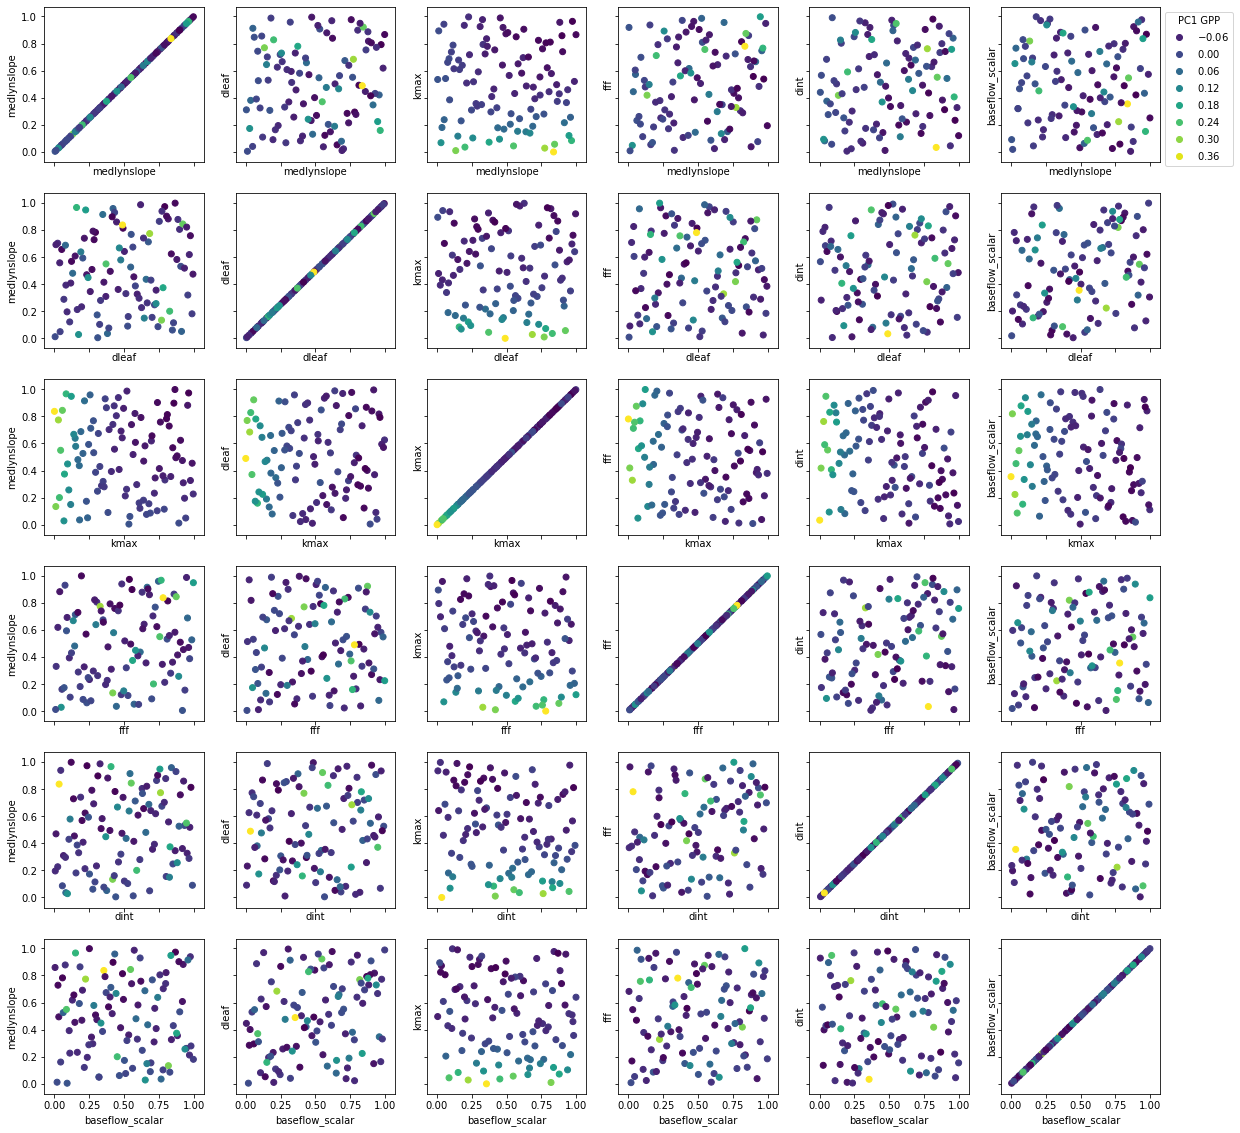

In [47]:
# test GPP mode 1
fig, axs = plt.subplots(npar, npar, figsize=(20, 20), sharex=True, sharey=True)
#axs = axs.ravel()
for i in range(npar):
    for j in range(npar):
        scatter=axs[i,j].scatter(inputdata[:,i],inputdata[:,j], label="CLM PPE", c=PPE_modes[0][:,0])
        axs[i,j].set_xlabel(in_vars[i])
        axs[i,j].set_ylabel(in_vars[j])
        if i == 0 and j == npar-1:
            axs[i,j].legend(*scatter.legend_elements(),bbox_to_anchor=(1, 1),title="PC1 GPP")

Visualize parameters in 2D mode space (first two modes only)

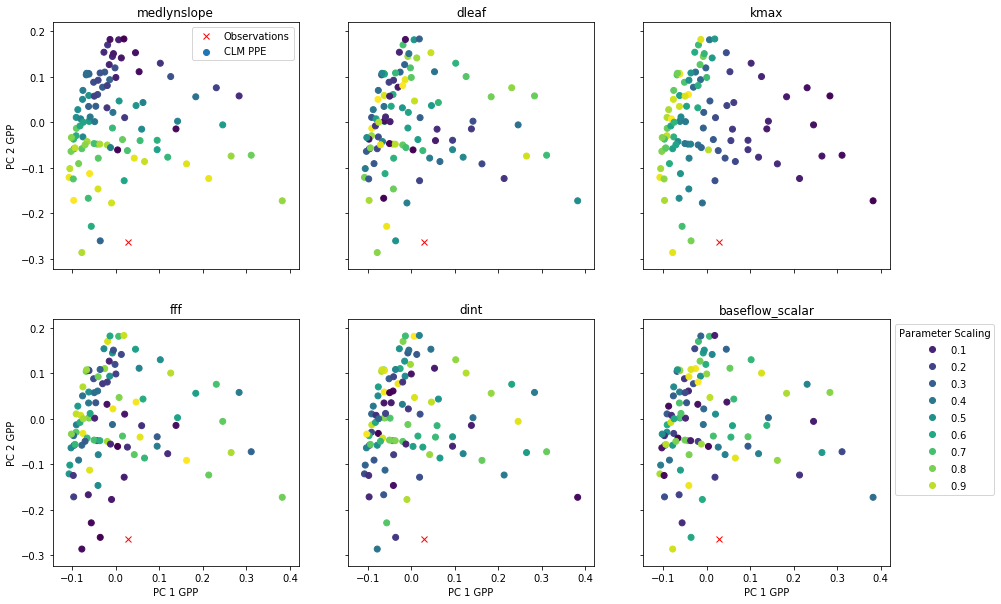

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.ravel()
for i in range(npar):
    scatter=axs[i].scatter(PPE_modes[0][:,0],PPE_modes[0][:,1], label="CLM PPE", c=inputdata[:,i])
    axs[i].plot(Fobs[0][:,0],Fobs[0][:,1], 'xr', label='Observations')
    if i > 2:
        axs[i].set_xlabel("PC 1 "+var[0])
    if i == 0 or i == 3:
        axs[i].set_ylabel("PC 2 "+var[0])
    axs[i].set_title(in_vars[i])
    if i == 0:
        axs[i].legend()
    if i == npar-1:
        axs[i].legend(*scatter.legend_elements(),bbox_to_anchor=(1, 1),title="Parameter Scaling")
#plt.savefig("EOF2vsEOF1_GPP_byparam_withobs.pdf")